In [ ]:
# 01 Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from datetime import datetime
import holidays

import lightgbm as lgb
import xgboost as xgb 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import os
import joblib

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

SEED = 86

In [2]:
df_2022 = pd.read_csv('../data/jepx/spot_summary_2022.csv', encoding='cp932')
df_2023 = pd.read_csv('../data/jepx/spot_summary_2023.csv', encoding='cp932')
df_2024 = pd.read_csv('../data/jepx/spot_summary_2024.csv', encoding='cp932')
df_2025 = pd.read_csv('../data/jepx/spot_summary_2025.csv', encoding='cp932')

In [3]:
dfs = [df_2022, df_2023, df_2024, df_2025]
df_all = pd.concat(dfs, ignore_index=True)
df_all['受渡日'] = pd.to_datetime(df_all['受渡日'])
df_all.head()

,受渡日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),エリアプライス北陸(円/kWh),エリアプライス関西(円/kWh),エリアプライス中国(円/kWh),エリアプライス四国(円/kWh),エリアプライス九州(円/kWh),売りブロック入札総量(kWh),売りブロック約定総量(kWh),買いブロック入札総量(kWh),買いブロック約定総量(kWh)
0,2022-04-01,1,17007100,16995100,15959150,11.97,10.39,10.39,12.12,12.12,12.12,12.12,12.12,12.12,12.12,3454600,3260650,1329300,1036000
1,2022-04-01,2,17252550,17306150,15896600,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,14.47,3686600,3317300,1698000,1360900
2,2022-04-01,3,17496550,17531950,15988650,15.00,24.32,24.32,24.32,14.49,14.49,14.49,14.49,14.49,14.49,3867450,3318250,2071250,1662200
3,2022-04-01,4,17994700,17695250,16003200,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,16.55,4106800,3320550,2270650,1844100
4,2022-04-01,5,18144250,17845100,16073050,17.30,24.32,24.32,24.32,16.55,16.55,16.55,16.55,16.55,16.55,4297450,3321000,2246900,1773350


In [4]:
# 02 Feature Engineering

# Date features
df_all['year'] = df_all['受渡日'].dt.year
# df_all['quarter'] = df_all['受渡日'].dt.quarter
df_all['month'] = df_all['受渡日'].dt.month
df_all['day_of_week'] = df_all['受渡日'].dt.day_of_week
# df_all['week_number'] = df_all['受渡日'].dt.isocalendar().week
df_all['day_of_year'] = df_all['受渡日'].dt.dayofyear

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]
for target in target_cols:
    df_all[f'{target}_lag336'] = df_all[target].shift(336)
    df_all[f'{target}_r336'] = df_all[target].rolling(336).mean()
    
    
# Cyclical encoding for periodic features
# df_all['quarter_sin'] = np.sin(2*np.pi*(df_all['quarter']-1)/4)
# df_all['quarter_cos'] = np.cos(2*np.pi*(df_all['quarter']-1)/4)

df_all['month_sin'] = np.sin(2*np.pi*(df_all['month']-1)/12)
df_all['month_cos'] = np.cos(2*np.pi*(df_all['month']-1)/12)

df_all['dow_sin'] = np.sin(2*np.pi*df_all['day_of_week']/7)
df_all['dow_cos'] = np.cos(2*np.pi*df_all['day_of_week']/7)

df_all['days_in_year'] = np.where(df_all['受渡日'].dt.is_leap_year, 366, 365)
df_all['frac_of_year'] = (df_all['day_of_year'] - 1) / df_all['days_in_year']
df_all['doy_sin'] = np.sin(2 * np.pi * df_all['frac_of_year'])
df_all['doy_cos'] = np.cos(2 * np.pi * df_all['frac_of_year'])

df_all['tod_sin'] = np.sin(2*np.pi*df_all['時刻コード']/48)
df_all['tod_cos'] = np.cos(2*np.pi*df_all['時刻コード']/48)


# Delete the data with Nan (due to the lag336)
print(f'Nan 削除前: {df_all.isnull().sum().sum()}')
df_all = df_all.dropna()
print(f'Nan 削除後: {df_all.isnull().sum().sum()}')


Nan 削除前: 6039
Nan 削除後: 0


In [27]:

df_all.head()



,受渡日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),エリアプライス北陸(円/kWh),エリアプライス関西(円/kWh),エリアプライス中国(円/kWh),エリアプライス四国(円/kWh),エリアプライス九州(円/kWh),売りブロック入札総量(kWh),売りブロック約定総量(kWh),買いブロック入札総量(kWh),買いブロック約定総量(kWh),year,month,day_of_week,day_of_year,エリアプライス北海道(円/kWh)_lag336,エリアプライス北海道(円/kWh)_r336,エリアプライス東北(円/kWh)_lag336,エリアプライス東北(円/kWh)_r336,エリアプライス東京(円/kWh)_lag336,エリアプライス東京(円/kWh)_r336,エリアプライス中部(円/kWh)_lag336,エリアプライス中部(円/kWh)_r336,エリアプライス北陸(円/kWh)_lag336,エリアプライス北陸(円/kWh)_r336,エリアプライス関西(円/kWh)_lag336,エリアプライス関西(円/kWh)_r336,エリアプライス中国(円/kWh)_lag336,エリアプライス中国(円/kWh)_r336,エリアプライス四国(円/kWh)_lag336,エリアプライス四国(円/kWh)_r336,エリアプライス九州(円/kWh)_lag336,エリアプライス九州(円/kWh)_r336,month_sin,month_cos,dow_sin,dow_cos,days_in_year,frac_of_year,doy_sin,doy_cos,tod_sin,tod_cos
336,2022-04-08,1,16527000,16866100,15076400,16.73,24.18,24.18,24.18,14.99,14.99,14.99,14.99,14.99,14.99,4412750,3342450,1394950,876550,2022,4,4,98,10.39,21.455238,10.39,20.799732,12.12,25.392530,12.12,17.311042,12.12,17.268065,12.12,17.268065,12.12,17.133542,12.12,16.997946,12.12,12.494583,1.0,6.123234e-17,-0.433884,-0.900969,365,0.265753,0.995105,-0.09882,0.130526,0.991445
337,2022-04-08,2,17598050,17142250,15129400,17.13,26.06,26.06,26.06,16.44,16.44,16.44,16.44,16.44,16.44,4690800,3394850,2013950,1361000,2022,4,4,98,14.47,21.489732,14.47,20.834226,14.47,25.427024,14.47,17.316905,14.47,17.273929,14.47,17.273929,14.47,17.139405,14.47,17.003810,14.47,12.500446,1.0,6.123234e-17,-0.433884,-0.900969,365,0.265753,0.995105,-0.09882,0.258819,0.965926
338,2022-04-08,3,18443800,17451250,15199350,18.38,28.11,28.11,28.11,16.44,16.44,16.44,16.44,16.44,16.44,4818250,3402200,2281650,1608350,2022,4,4,98,24.32,21.501012,24.32,20.845506,24.32,25.438304,14.49,17.322708,14.49,17.279732,14.49,17.279732,14.49,17.145208,14.49,17.009613,14.49,12.506250,1.0,6.123234e-17,-0.433884,-0.900969,365,0.265753,0.995105,-0.09882,0.382683,0.923880
339,2022-04-08,4,18499750,17612400,15275650,20.07,28.17,28.17,28.17,16.95,16.95,16.95,16.95,16.95,16.95,4827800,3402300,2471500,1832650,2022,4,4,98,16.55,21.535595,16.55,20.880089,16.55,25.472887,16.55,17.323899,16.55,17.280923,16.55,17.280923,16.55,17.146399,16.55,17.010804,16.55,12.507440,1.0,6.123234e-17,-0.433884,-0.900969,365,0.265753,0.995105,-0.09882,0.500000,0.866025
340,2022-04-08,5,18345400,17765050,15296450,24.18,28.30,28.30,28.30,18.38,18.38,18.38,18.38,18.38,18.38,4713750,3403950,2533400,1936350,2022,4,4,98,24.32,21.547440,24.32,20.891935,24.32,25.484732,16.55,17.329345,16.55,17.286369,16.55,17.286369,16.55,17.151845,16.55,17.016250,16.55,12.512887,1.0,6.123234e-17,-0.433884,-0.900969,365,0.265753,0.995105,-0.09882,0.608761,0.793353


In [5]:
# 03 Data split into train, validation, test

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

In [6]:
# 04 Get duration

train_start = df_train['受渡日'].min()
train_end = df_train['受渡日'].max()

val_start = df_val['受渡日'].min()
val_end = df_val['受渡日'].max()

test_start = df_test['受渡日'].min()
test_end = df_test['受渡日'].max()

# Show
print(f'Train_start: {train_start.date()} - Train_end: {train_end.date()}')
print(f'Val_start: {val_start.date()} - Val_end: {val_end.date()}')
print(f'Test_start: {test_start.date()} - Test_end: {test_end.date()}')

Train_start: 2022-04-08 - Train_end: 2025-10-12
Val_start: 2025-10-13 - Val_end: 2025-10-19
Test_start: 2025-10-20 - Test_end: 2025-10-26


In [7]:
# 05 Create MAE & RMSE DataFrame 
target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

df_mae_results = pd.DataFrame({'Region': target_cols})
df_rmse_results = pd.DataFrame({'Region': target_cols})


# XGBoost

In [21]:
# 01 モデル保存フォルダ
MODEL_DIR = 'models_XGBoost'
os.makedirs(MODEL_DIR, exist_ok=True)


# 02 結果格納用
df_mae_results['XGBoost'] = 0
df_rmse_results['XGBoost'] = 0


# 03 学習用特徴量の選択
params = {
    'objective': 'reg:absoluteerror',
    'silent': 1,
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED
}
num_round = 100000

# 04 各地域ごとにモデルを学習・保存
for target in target_cols:
    print(f'予測地域: {target}')
    
    # A Select columns
    select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    f'{target}_lag336', f'{target}_r336'
]
    
    X_train = df_train[select_column]
    y_train = df_train[target]

    X_val = df_val[select_column]
    y_val = df_val[target]

    X_test = df_test[select_column]
    y_test = df_test[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    
    # B Val set
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=1000, verbose_eval=1000)
    
    
    # C Predict
    y_pred = model.predict(dtest)


    # D Calculate MAE and RMSE
    mae  = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)


    # E Save MAE and RMSE
    df_mae_results.loc[df_mae_results["Region"] == target, "XGBoost"] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, "XGBoost"] = rmse

    
    # E　Save model
    safe_name = target.replace("(円/kWh)", "").replace("エリアプライス", "").strip()
    model_path = os.path.join(MODEL_DIR, f"xgboost_{safe_name}.json")
    model.save_model(model_path)
    print(f"Saved model → {model_path}")


予測地域: エリアプライス北海道(円/kWh)
[0]	train-mae:5.42823	eval-mae:5.29026
[1000]	train-mae:1.62179	eval-mae:4.26242
[1111]	train-mae:1.58107	eval-mae:4.30069
Saved model → models_XGBoost\xgboost_北海道.json
予測地域: エリアプライス東北(円/kWh)
[0]	train-mae:5.31728	eval-mae:2.99334
[1000]	train-mae:1.57325	eval-mae:2.68002
[1078]	train-mae:1.54376	eval-mae:2.69489
Saved model → models_XGBoost\xgboost_東北.json
予測地域: エリアプライス東京(円/kWh)
[0]	train-mae:5.08112	eval-mae:2.94837
[1000]	train-mae:1.35793	eval-mae:1.99792
[1077]	train-mae:1.33330	eval-mae:2.00738
Saved model → models_XGBoost\xgboost_東京.json
予測地域: エリアプライス中部(円/kWh)
[0]	train-mae:4.98399	eval-mae:2.98548
[1000]	train-mae:1.50402	eval-mae:1.91568
[1087]	train-mae:1.47812	eval-mae:1.90020
Saved model → models_XGBoost\xgboost_中部.json
予測地域: エリアプライス北陸(円/kWh)
[0]	train-mae:5.06988	eval-mae:3.32488
[1000]	train-mae:1.46939	eval-mae:2.33637
[1064]	train-mae:1.44751	eval-mae:2.35722
Saved model → models_XGBoost\xgboost_北陸.json
予測地域: エリアプライス関西(円/kWh)
[0]	train-mae:5.0899

In [22]:
# MAE
df_mae_results

,Region,XGBoost,LightGBM
0,エリアプライス北海道(円/kWh),4.452537,0
1,エリアプライス東北(円/kWh),2.194733,0
2,エリアプライス東京(円/kWh),2.041508,0
3,エリアプライス中部(円/kWh),1.584306,0
4,エリアプライス北陸(円/kWh),1.560053,0
5,エリアプライス関西(円/kWh),1.575172,0
6,エリアプライス中国(円/kWh),1.836937,0
7,エリアプライス四国(円/kWh),1.224445,0
8,エリアプライス九州(円/kWh),1.954853,0


In [23]:
# RMSE
df_rmse_results

,Region,XGBoost,LightGBM
0,エリアプライス北海道(円/kWh),7.870451,0
1,エリアプライス東北(円/kWh),3.369574,0
2,エリアプライス東京(円/kWh),3.347258,0
3,エリアプライス中部(円/kWh),2.000465,0
4,エリアプライス北陸(円/kWh),1.974922,0
5,エリアプライス関西(円/kWh),1.993466,0
6,エリアプライス中国(円/kWh),2.220914,0
7,エリアプライス四国(円/kWh),1.693355,0
8,エリアプライス九州(円/kWh),2.480937,0


# LightGBM

In [ ]:
# # 03 Training

# target = 'エリアプライス東京(円/kWh)'

# select_column = [
#     'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
#     'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
# ]

# df_train = df_all[:-48*7] # 最後の336行を除外
# df_test = df_all[-48*7:] # 最後の336行を取得

# df_val = df_train[-48*7:] # 最後の336行を取得
# df_train = df_train[:-48*7] # 最後の336行を除外

# print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
# print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
# print('-----------------------------------------')

# X_train = df_train[select_column]
# y_train = df_train[target]

# X_val = df_val[select_column]
# y_val = df_val[target]

# X_test = df_test[select_column]
# y_test = df_test[target]

# params = {
#     'objective': 'regression',
#     'metric': 'mae',
#     'num_iterations':100000,
#     'learning_rate': 0.001,
#     'num_leaves': 16,
#     'max_depth': -1,
#     'early_stopping_rounds': 1000,
#     'min_data_in_leaf': 20,
#     'min_sum_hessian_in_leaf': 1e-3,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 1,
#     'feature_fraction': 0.9,
#     'lambda_l1': 0.0,
#     'lambda_l2': 0.0,
#     'random_state': SEED,
#     'verbosity': -1,
# }

# model = lgb.LGBMRegressor(**params)

# model.fit(
#     X_train, y_train,
#     eval_set = [(X_val, y_val)],
#     eval_metric = 'mae', 
#     callbacks = [
#         lgb.log_evaluation(1000)
#     ]
# )

Len train: 61296, Len val: 336, Len test: 336
Tail train: 61967   2025-10-12
Name: 受渡日, dtype: datetime64[ns], Len val: 62303   2025-10-19
Name: 受渡日, dtype: datetime64[ns], Len test: 62639   2025-10-26
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
[1000]	valid_0's l1: 2.56363
[2000]	valid_0's l1: 2.06752
[3000]	valid_0's l1: 1.85062
[4000]	valid_0's l1: 1.78667
[5000]	valid_0's l1: 1.75457
[6000]	valid_0's l1: 1.73729
[7000]	valid_0's l1: 1.7337
[8000]	valid_0's l1: 1.7312
[9000]	valid_0's l1: 1.72726
[10000]	valid_0's l1: 1.72404
[11000]	valid_0's l1: 1.72204
[12000]	valid_0's l1: 1.72038
[13000]	valid_0's l1: 1.71994


,boosting_type,'gbdt'
,num_leaves,16
,max_depth,-1
,learning_rate,0.001
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
# # 04 Test - 再学習していない

# y_pred = model.predict(X_test)

# mae  = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Test MAE: {mae:.4f}')
# print(f'Test RMSE: {rmse:.4f}')


Test MAE: 1.8828
Test RMSE: 3.3080


In [ ]:
# 05 Train-Test with all area

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_iterations':100000,
    'learning_rate': 0.001,
    'num_leaves': 16,
    'max_depth': -1,
    'early_stopping_rounds': 1000,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-3,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'random_state': SEED,
    'verbosity': -1,
}

df_mae_results['LightGBM'] = 0
df_rmse_results['LightGBM'] = 0


# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    # 1 Select columns
    select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    f'{target}_lag336', f'{target}_r336'
]
    
    X_train = df_train[select_column]
    y_train = df_train[target]

    X_val = df_val[select_column]
    y_val = df_val[target]

    X_test = df_test[select_column]
    y_test = df_test[target]

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set = [(X_val, y_val)],
        eval_metric = 'mae', 
        callbacks = [
            lgb.log_evaluation(1000)
        ]
    )

    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    
    df_mae_results.loc[df_mae_results["Region"] == target, "LightGBM"] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, "LightGBM"] = rmse


# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print('--------MAE--------')
print(df_mae_results)
print('--------RSME--------')
print(df_rmse_results)


Len train: 61296, Len val: 336, Len test: 336
Tail train: 61967   2025-10-12
Name: 受渡日, dtype: datetime64[ns], Len val: 62303   2025-10-19
Name: 受渡日, dtype: datetime64[ns], Len test: 62639   2025-10-26
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
[1000]	valid_0's l1: 4.6847
[2000]	valid_0's l1: 4.54138
[3000]	valid_0's l1: 4.49
[4000]	valid_0's l1: 4.41152
[5000]	valid_0's l1: 4.36712
[6000]	valid_0's l1: 4.3332
[7000]	valid_0's l1: 4.30651
[8000]	valid_0's l1: 4.29162
[9000]	valid_0's l1: 4.278
[10000]	valid_0's l1: 4.2693
[11000]	valid_0's l1: 4.26368
[12000]	valid_0's l1: 4.25961
[13000]	valid_0's l1: 4.25601
[14000]	valid_0's l1: 4.25311
[15000]	valid_0's l1: 4.25163
[16000]	valid_0's l1: 4.251
[17000]	valid_0's l1: 4.251
[18000]	valid_0's l1: 4.25029
予測地域: エリアプライス東北(円/kWh)
[1000]	valid_0's l1: 2.53721
[2000]	valid_0's l1: 2.26563
[3000]	valid_0's l1: 2.15672
[4000]	valid_0's l1: 2.07823
[5000]	valid_0's l1: 2.04749
[6000]	valid

KeyboardInterrupt: 

In [ ]:
# 06 Save Hyperparams

outdir = Path('artifacts')
outdir.mkdir(exist_ok=True)

# Save
df_params = pd.DataFrame([params])
df_params_t = df_params.T
df_params_t.columns = ['LightGBM Hyper Params']
df_params_t = df_params_t.astype({'LightGBM Hyper Params': 'string'})   

display(df_params_t)
df_params_t.to_parquet(outdir / 'LightGBM_params.parquet', index=True)

,LightGBM Hyper Params
objective,regression
metric,mae
num_iterations,100000
learning_rate,0.001
num_leaves,16
max_depth,-1
early_stopping_rounds,1000
min_data_in_leaf,20
min_sum_hessian_in_leaf,0.001
bagging_fraction,0.9


In [ ]:
# 03 Training
target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'reg:absoluteerror',
    'silent': 1,
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED
}
num_round = 100000

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=1000, verbose_eval=1000)

Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
[0]	train-mae:5.20167	eval-mae:3.09643
[1000]	train-mae:1.36652	eval-mae:3.89402
[1017]	train-mae:1.36011	eval-mae:3.88624


In [272]:
# 04 Test - 再学習していない

y_pred = model.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MAE: 1.4069
Test RMSE: 1.8099


In [273]:
# 05 Train-Test with all area
# Pre set

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

params = {
    'objective': 'reg:absoluteerror',
    'silent': 1,
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.0,
    'alpha': 0.0,
    'lambda': 1.0,
    'min_child_weight': 1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED
}

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

df_mae_results['XGBoost'] = 0
df_rmse_results['XGBoost'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    # 1 Select columns
    select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
    'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    f'{target}_lag336', f'{target}_r336'
]
    
    X_train = df_train[select_column]
    y_train = df_train[target]

    X_val = df_val[select_column]
    y_val = df_val[target]

    X_test = df_test[select_column]
    y_test = df_test[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    num_round = 100000

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=1000, verbose_eval=1000)
    
    y_pred = model.predict(dtest)

    mae  = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, "XGBoost"] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, "XGBoost"] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print('--------MAE--------')
print(df_mae_results)
print('--------RSME--------')
print(df_rmse_results)


Len train: 58416, Len val: 336, Len test: 336
Tail train: 58751   2025-08-06
Name: 受渡日, dtype: datetime64[ns], Len val: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
[0]	train-mae:5.49838	eval-mae:3.02307
[1000]	train-mae:1.62231	eval-mae:3.83108
[1017]	train-mae:1.61597	eval-mae:3.82266
予測地域: エリアプライス東北(円/kWh)
[0]	train-mae:5.44387	eval-mae:2.76173
[1000]	train-mae:1.57095	eval-mae:4.04969
[1007]	train-mae:1.56809	eval-mae:4.04861
予測地域: エリアプライス東京(円/kWh)
[0]	train-mae:5.20167	eval-mae:3.09643
[1000]	train-mae:1.36652	eval-mae:3.89402
[1017]	train-mae:1.36011	eval-mae:3.88624
予測地域: エリアプライス中部(円/kWh)
[0]	train-mae:5.10229	eval-mae:2.80243
[1000]	train-mae:1.52835	eval-mae:2.80933
[1379]	train-mae:1.42267	eval-mae:2.75241
予測地域: エリアプライス北陸(円/kWh)
[0]	train-mae:5.18201	eval-mae:3.16790
[1000]	train-mae:1.47265	eval-mae:3.34659
[1191]	train-mae:1.40956	eval-mae:

# Linear Regression

In [274]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

model = LinearRegression().fit(X_train, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [275]:
# 04 Test - 再学習していない

r2_score = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5644080275188794, Coefficients: [-0.1997035   2.57603895  3.85653532  1.15983212 -0.35028302 -3.53859218
 -3.35604812 -2.17360597  0.62020585  0.29857841  0.64135461], Intercept: 405.00887292610975
Test MAE: 2.1304
Test RMSE: 2.7090


In [276]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

df_mae_results['Linear Regression'] = 0
df_rmse_results['Linear Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = LinearRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Linear Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Linear Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226
6   エリアプライス中国(円/kWh)  2.516918  1.452028           2.094666
7   エリアプライス四国(円/kWh)  2.151759  1.926346           1.997347
8   エリアプライス九州(円/kWh)  2.818667  1.602318           

# Lasso Regression

In [277]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = linear_model.Lasso(alpha=0.1).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [278]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5608677869623373, Coefficients: [-0.15544891 -0.         -0.          0.71694749 -0.14973378 -0.05272689
 -0.09011999 -1.43658644  0.33844137  2.83630556  4.18040319], Intercept: 15.964190325435736
Test MAE: 2.0682
Test RMSE: 2.6596


In [279]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Lasso Regression'] = 0
df_rmse_results['Lasso Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = linear_model.Lasso(alpha=0.1).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Lasso Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Lasso Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002
6   エリアプライス中国(円/kWh)  2.516918  1.452028     

# Ridge Regression

In [280]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = linear_model.Ridge(alpha=1.0).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [281]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.5644080211490616, Coefficients: [-0.20498789  1.80448182  2.7248123   0.82031868 -0.24762399 -2.46125662
 -2.38783255 -1.53695123  0.43854606  2.83495044  4.24904701], Intercept: 15.964190325435736
Test MAE: 2.1304
Test RMSE: 2.7090


In [282]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Ridge Regression'] = 0
df_rmse_results['Ridge Regression'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = linear_model.Ridge(alpha=0.1).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Ridge Regression'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Ridge Regression'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# Elastic Net

In [283]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [284]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
coefficients = model.coef_
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.560424109505965, Coefficients: [-0.35014222 -0.         -0.          0.73068271 -0.19032927 -0.16127671
 -0.13677285 -1.41655897  0.37019243  2.83248899  3.87345039], Intercept: 15.964190325435741
Test MAE: 2.0642
Test RMSE: 2.6714


In [285]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['Elastic Net'] = 0
df_rmse_results['Elastic Net'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'Elastic Net'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'Elastic Net'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# SVR

In [286]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  

model = SVR(
    kernel="rbf",
    degree=3,
    gamma="scale",
    coef0=0.0,
    tol=1e-3,
    C=1.0,
    epsilon=0.2,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1
).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [287]:
# 04 Test - 再学習していない

r2_score = model.score(X_train_scaled, y_train)
intercept = model.intercept_
print(f'R2: {r2_score}, Coefficients: {coefficients}, Intercept: {intercept}')

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

R2: 0.7336368386180023, Coefficients: [-0.35014222 -0.         -0.          0.73068271 -0.19032927 -0.16127671
 -0.13677285 -1.41655897  0.37019243  2.83248899  3.87345039], Intercept: [24.19210831]
Test MAE: 1.9245
Test RMSE: 2.4360


In [288]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['SVR'] = 0
df_rmse_results['SVR'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = SVR(
    kernel="rbf",
    degree=3,
    gamma="scale",
    coef0=0.0,
    tol=1e-3,
    C=1.0,
    epsilon=0.2,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1
    ).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'SVR'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'SVR'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# KNN

In [289]:
# 03 Training

target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  

model = KNeighborsRegressor(
    n_neighbors=50,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1
).fit(X_train_scaled, y_train)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------


In [290]:
# 04 Test - 再学習していない

y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MAE: 2.4890
Test RMSE: 3.1136


In [291]:
# 05 Train-Test with all area

target_cols = [
    'エリアプライス北海道(円/kWh)',
    'エリアプライス東北(円/kWh)',
    'エリアプライス東京(円/kWh)',
    'エリアプライス中部(円/kWh)',
    'エリアプライス北陸(円/kWh)',
    'エリアプライス関西(円/kWh)',
    'エリアプライス中国(円/kWh)',
    'エリアプライス四国(円/kWh)',
    'エリアプライス九州(円/kWh)',
]

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

print(f'Len train: {len(df_train)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_test = df_test[select_column]
y_test = df_test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

df_mae_results['KNN'] = 0
df_rmse_results['KNN'] = 0

# 各地域ごとにループ
for target in target_cols:
    print(f'予測地域: {target}')
    
    y_train, y_test = df_train[target], df_test[target]

    model = KNeighborsRegressor(
    n_neighbors=50,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1
    ).fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    df_mae_results.loc[df_mae_results["Region"] == target, 'KNN'] = mae
    df_rmse_results.loc[df_rmse_results["Region"] == target, 'KNN'] = rmse

# 表形式にまとめる
df_mae_results = pd.DataFrame(df_mae_results)
df_rmse_results = pd.DataFrame(df_rmse_results)
print(df_mae_results)
print(df_rmse_results)

Len train: 58752, Len test: 336
Tail train: 59087   2025-08-13
Name: 受渡日, dtype: datetime64[ns], Len test: 59423   2025-08-20
Name: 受渡日, dtype: datetime64[ns]
-----------------------------------------
予測地域: エリアプライス北海道(円/kWh)
予測地域: エリアプライス東北(円/kWh)
予測地域: エリアプライス東京(円/kWh)
予測地域: エリアプライス中部(円/kWh)
予測地域: エリアプライス北陸(円/kWh)
予測地域: エリアプライス関西(円/kWh)
予測地域: エリアプライス中国(円/kWh)
予測地域: エリアプライス四国(円/kWh)
予測地域: エリアプライス九州(円/kWh)
              Region  LightGBM   XGBoost  Linear Regression  Lasso Regression  \
0  エリアプライス北海道(円/kWh)  3.092928  2.796934           3.446297          3.324270   
1   エリアプライス東北(円/kWh)  1.913817  1.368339           2.165518          2.071845   
2   エリアプライス東京(円/kWh)  1.769082  1.406918           2.130391          2.068184   
3   エリアプライス中部(円/kWh)  2.565842  1.475554           2.264183          2.227561   
4   エリアプライス北陸(円/kWh)  2.871607  1.356805           2.350655          2.356141   
5   エリアプライス関西(円/kWh)  2.885098  1.370141           2.347226          2.353002   
6   エリアプライス中国(円/kWh)  2.

# LSTM

In [5]:
target = 'エリアプライス東京(円/kWh)'

data_X = []
data_y = []

# 時数 (どこまで過去のデータを考慮するか)
p = 336

for i in range(len(df_all)-p):
    data_X.append(df_all[target][i:i+p]) # Type: List
    data_y.append(df_all[target][i+p]) # Type: List

data_X = np.array(data_X) # Type: np.array
data_y = np.array(data_y) # Type: np.array

In [6]:
# Split train and test data
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')

X_train: 41126, X_test: 17626


In [7]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train_n = scaler_x.fit_transform(X_train)
X_test_n = scaler_x.transform(X_test)
scaler_y = MinMaxScaler()
y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1))

In [8]:
# データの確認  - (データの数, 説明変数の数(p))になっている。
print(X_train_n.shape, X_test_n.shape)

(41126, 336) (17626, 336)


In [9]:
# データの形を変更  - （データの数, 系列数, 説明変数の数(p)）に変更する。
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], 1, X_train_n.shape[1]))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], 1, X_test_n.shape[1]))

In [10]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models

# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)


In [11]:
# モデルの学習
result = model.fit(
    X_train_n,
    y_train_n,
    batch_size=10,
    epochs=100
)

Epoch 1/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.8679e-04
Epoch 2/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.2777e-04
Epoch 3/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6.9926e-05
Epoch 4/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.9609e-05
Epoch 5/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.0832e-05
Epoch 6/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.0492e-05
Epoch 7/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.1073e-05
Epoch 8/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.2635e-05
Epoch 9/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.2240e-05
Epoch 10/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7950e-05
Epoch 11/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.0184e-05
Epoch 12/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.5650e-05
Epoch 13/100
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.3865e-05
Epoch 14/100
4113/4113 ━━━━━━━━━━━

In [12]:
# 予測値の算出
y_pred_n = model.predict(X_test_n)

#正規化の復元
y_pred = scaler_y.inverse_transform(y_pred_n).flatten()


mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test MAE: 0.0682
Test RMSE: 0.0855


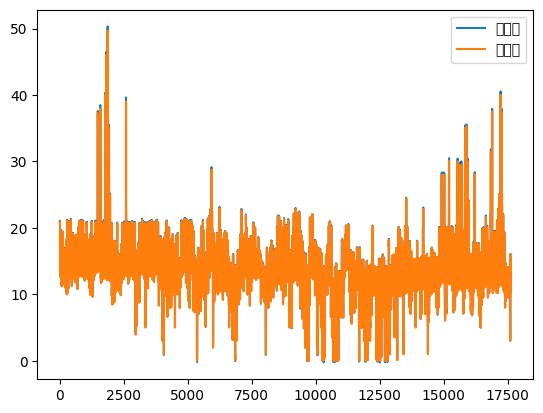

In [13]:
plt.plot(y_pred, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

# LSTM2

In [17]:
target = 'エリアプライス東京(円/kWh)'

data_X = []
data_y = []

# 時数 (どこまで過去のデータを考慮するか)
p = 336

for i in range(len(df_all)-p):
    data_X.append(df_all[target][i:i+p]) # Type: List
    data_y.append(df_all[target][i+p]) # Type: List

data_X = np.array(data_X) # Type: np.array
data_y = np.array(data_y) # Type: np.array

In [20]:
# Split train, val and test data
X_train = data_X[:-48*7] # 最後の336行を除外
X_test = data_X[-48*7:] # 最後の336行を取得

X_val = X_train[-48*7:] # 最後の336行を取得
X_train = X_train[:-48*7] # 最後の336行を除外

y_train = data_y[:-48*7] # 最後の336行を除外
y_test = data_y[-48*7:] # 最後の336行を取得

y_val = y_train[-48*7:] # 最後の336行を取得
y_train = y_train[:-48*7] # 最後の336行を除外

print(f'X_train: {len(X_train)}, X_val: {len(X_val)} X_test: {len(X_test)}')

# print(f"Tail train: {X_train.tail(1)['受渡日']}, Len test: {X_test.tail(1)['受渡日']}")
# print(f'X_train[-1].sum(): {X_train[-1].sum()}')
# print(f'X_val[-1].sum(): {X_val[-1].sum()}')
# print(f'X_test[-1].sum(): {X_test[-1].sum()}')
# print('-----------------------------------------')

X_train: 58080, X_val: 336 X_test: 336


In [21]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train_n = scaler_x.fit_transform(X_train)
X_val_n = scaler_x.transform(X_val)
X_test_n = scaler_x.transform(X_test)
scaler_y = MinMaxScaler()
y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_val_n = scaler_y.transform(y_val.reshape(len(y_val),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1))

In [22]:
# データの確認  - (データの数, 説明変数の数(p))になっている。
print(X_train_n.shape, X_val_n.shape, X_test_n.shape)

(58080, 336) (336, 336) (336, 336)


In [23]:
# データの形を変更  - （データの数, 系列数, 説明変数の数(p)）に変更する。
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], 1, X_train_n.shape[1]))
X_val_n = np.reshape(X_val_n, (X_val_n.shape[0], 1, X_val_n.shape[1]))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], 1, X_test_n.shape[1]))

In [24]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models


# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mae',
    optimizer='adam'
)


In [25]:
# モデルの実装
from keras.layers import LSTM, Dense
from keras import models
from tensorflow.keras.optimizers import Adam


# 時数 (どこまで過去のデータを考慮するか)
p = 336

# モデルの実装
model = models.Sequential()
model.add(
    LSTM(
        100,
        activation='tanh',
        input_shape=(1, p)
    )
)
model.add(Dense(1, activation='linear'))

# 学習設定
model.compile(
    loss='mae',
    optimizer=Adam(learning_rate=1e-3)
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',      # 検証損失を監視
    patience=8,              # 8エポック連続で改善しなければ停止
    restore_best_weights=True,
    min_delta=0.0,           # これ以上の改善がなければ「停滞」とみなす
    verbose=1
)

result = model.fit(
    X_train_n, y_train_n,
    validation_data=(X_val_n, y_val_n),
    batch_size=10,
    epochs=100,
    shuffle=False,
    callbacks=[es]
)

Epoch 1/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0131 - val_loss: 0.0085
Epoch 2/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 3/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 4/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 5/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 6/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 7/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 8/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 9/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 11/100
5808/5808 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 12/1

In [28]:
# 予測値の算出
y_pred_n = model.predict(X_test_n)

#正規化の復元
y_pred = scaler_y.inverse_transform(y_pred_n).flatten()


mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test MAE: 1.2308
Test RMSE: 1.5664


In [ ]:
target = 'エリアプライス東京(円/kWh)'

select_column = [
    'year', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'tod_sin', 'tod_cos',
    'エリアプライス東京(円/kWh)_lag336', 'エリアプライス東京(円/kWh)_r336'
]

df_train = df_all[:-48*7] # 最後の336行を除外
df_test = df_all[-48*7:] # 最後の336行を取得

df_val = df_train[-48*7:] # 最後の336行を取得
df_train = df_train[:-48*7] # 最後の336行を除外

print(f'Len train: {len(df_train)}, Len val: {len(df_val)}, Len test: {len(df_test)}')
print(f"Tail train: {df_train.tail(1)['受渡日']}, Len val: {df_val.tail(1)['受渡日']}, Len test: {df_test.tail(1)['受渡日']}")
print('-----------------------------------------')

X_train = df_train[select_column]
y_train = df_train[target]

X_val = df_val[select_column]
y_val = df_val[target]

X_test = df_test[select_column]
y_test = df_test[target]

# Save MAE & RSME 

In [292]:
from pathlib import Path

outdir = Path("artifacts")
outdir.mkdir(exist_ok=True)

# Save
df_mae_results.to_parquet(outdir / "df_mae_results.parquet", index=False)
df_rmse_results.to_parquet(outdir / "df_rmse_results.parquet", index=False)


In [293]:
df_mae_results

,Region,LightGBM,XGBoost,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net,SVR,KNN
0,エリアプライス北海道(円/kWh),3.092928,2.796934,3.446297,3.324270,3.446296,3.322515,3.335704,3.319845
1,エリアプライス東北(円/kWh),1.913817,1.368339,2.165518,2.071845,2.165513,2.072985,2.684432,2.417305
2,エリアプライス東京(円/kWh),1.769082,1.406918,2.130391,2.068184,2.130390,2.064247,1.924538,2.488993
3,エリアプライス中部(円/kWh),2.565842,1.475554,2.264183,2.227561,2.264186,2.236624,2.171275,2.901029
4,エリアプライス北陸(円/kWh),2.871607,1.356805,2.350655,2.356141,2.350660,2.378747,2.411155,3.221498
5,エリアプライス関西(円/kWh),2.885098,1.370141,2.347226,2.353002,2.347232,2.370843,2.531731,3.220873
6,エリアプライス中国(円/kWh),2.516918,1.452028,2.094666,2.102660,2.094672,2.102257,1.898994,2.610990
7,エリアプライス四国(円/kWh),2.151759,1.926346,1.997347,1.950255,1.997352,1.963685,1.777900,2.590504
8,エリアプライス九州(円/kWh),2.818667,1.602318,2.233973,2.188130,2.233974,2.165925,1.405259,2.481850


In [294]:
df_rmse_results

,Region,LightGBM,XGBoost,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net,SVR,KNN
0,エリアプライス北海道(円/kWh),5.473329,4.554469,6.038479,5.995096,6.038480,5.993498,4.956513,4.914933
1,エリアプライス東北(円/kWh),2.593934,1.794924,2.864766,2.771974,2.864760,2.772367,3.116584,2.920205
2,エリアプライス東京(円/kWh),2.332957,1.809948,2.708982,2.659566,2.708981,2.671404,2.435983,3.113558
3,エリアプライス中部(円/kWh),3.280572,1.890655,2.935454,2.917217,2.935457,2.920040,2.897715,3.913168
4,エリアプライス北陸(円/kWh),3.562512,1.833385,3.122539,3.143603,3.122547,3.145507,3.155033,4.280628
5,エリアプライス関西(円/kWh),3.563258,1.872600,3.136841,3.158411,3.136849,3.155510,3.241526,4.279430
6,エリアプライス中国(円/kWh),3.043924,1.822663,2.772199,2.763377,2.772208,2.778338,2.342050,3.441352
7,エリアプライス四国(円/kWh),2.866855,2.733425,2.665476,2.648914,2.665479,2.657903,2.515585,3.339586
8,エリアプライス九州(円/kWh),3.279979,1.950128,2.828204,2.774602,2.828206,2.768313,1.804539,3.257024
